In [1]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.svm import SVR
from sklearn.ensemble import (RandomForestRegressor, VotingRegressor, StackingRegressor, 
                                ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, make_scorer
import xgboost as xgb
import catboost as cat
import lightgbm as lgbm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [3]:
seed=42

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv', index_col=[0])
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

In [5]:
print('Train missing values :\n')
for col in test.columns:
    if col!='price':
        null_values=test[col].isnull().sum()
        print(col, '__', null_values, '__ Missing Percentage :', (null_values/train.shape[0]*100).__ceil__(),'%')

Train missing values :

id __ 0 __ Missing Percentage : 0 %
brand __ 0 __ Missing Percentage : 0 %
model __ 0 __ Missing Percentage : 0 %
model_year __ 0 __ Missing Percentage : 0 %
milage __ 0 __ Missing Percentage : 0 %
fuel_type __ 3383 __ Missing Percentage : 2 %
engine __ 0 __ Missing Percentage : 0 %
transmission __ 0 __ Missing Percentage : 0 %
ext_col __ 0 __ Missing Percentage : 0 %
int_col __ 0 __ Missing Percentage : 0 %
accident __ 1632 __ Missing Percentage : 1 %
clean_title __ 14239 __ Missing Percentage : 8 %


In [6]:
print('train missing values :\n')
for col in train.columns:
    if col!='price':
        null_values=train[col].isnull().sum()
        print(col, '__', null_values, '__ Missing Percentage :', (null_values/train.shape[0]*100).__ceil__(),'%')

train missing values :

brand __ 0 __ Missing Percentage : 0 %
model __ 0 __ Missing Percentage : 0 %
model_year __ 0 __ Missing Percentage : 0 %
milage __ 0 __ Missing Percentage : 0 %
fuel_type __ 5083 __ Missing Percentage : 3 %
engine __ 0 __ Missing Percentage : 0 %
transmission __ 0 __ Missing Percentage : 0 %
ext_col __ 0 __ Missing Percentage : 0 %
int_col __ 0 __ Missing Percentage : 0 %
accident __ 2452 __ Missing Percentage : 2 %
clean_title __ 21419 __ Missing Percentage : 12 %


In [7]:
# train['accident'] = train['accident'].fillna('None reported')
train['clean_title'] = train['clean_title'].fillna('No')
# test['accident'] = test['accident'].fillna('None reported')
test['clean_title'] = test['clean_title'].fillna('No')

In [8]:
# train['fuel_type'] = train['fuel_type'].replace(['–', 'not supported'], np.nan)
# test['fuel_type'] = test['fuel_type'].replace(['–', 'not supported'], np.nan)

In [9]:
train['clean_title'].value_counts()

clean_title
Yes    167114
No      21419
Name: count, dtype: int64

In [10]:
train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [11]:
train['engine'].value_counts().head(20)

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2841
2.0L I4 16V GDI DOHC Turbo                               2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            2451
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel            2436
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2187
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2138
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2134
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2084
295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            1917
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel            1910
302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            1895
3.5L V6 24V PDI DOHC Twin Turbo                          1842
301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel             1578
5.7L V8 16V MPFI OHV                                     1540
4

In [12]:
train['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [13]:
print(test['fuel_type'].isnull().sum())

3383


In [14]:
def get_mode(series):
    mode = series.mode()[:5]
    return mode.to_list() if not mode.empty else [None]

group = train.groupby('fuel_type')['engine'].apply(lambda x: get_mode(x)).to_dict()

In [15]:
fuel_noisy_rows = train[(train['fuel_type']=='–') | (train['fuel_type']=='not supported')].index

In [16]:
# train['engine'].replace('–', np.nan, inplace=True)
# test['engine'].replace('–', np.nan, inplace=True)
# train.loc[train['engine']=='–', 'engine'] = np.nan
# test.loc[train['engine']=='–', 'engine'] = np.nan

# train.loc[train['fuel_type']=='–', 'fuel_type'] = np.nan
# test.loc[train['engine']=='–', 'fuel_type'] = np.nan

In [17]:
import pandas as pd

def get_modes(series):
    modes = series.mode() 
    return modes.tolist() if not modes.empty else [None] 

brand_model_fuel_mappings_train = train.groupby(['brand','model', 'model_year'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
brand_model_fuel_mappings_test = test.groupby(['brand','model', 'model_year'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
engine_fuel_map_train = train.groupby('engine')['fuel_type'].agg(get_modes).to_dict()
engine_fuel_map_test = test.groupby('engine')['fuel_type'].agg(get_modes).to_dict()

def impute_fuel_type_by_engine(row, engine_fuel_map):
    if pd.isnull(row['fuel_type']):
        possible_modes = engine_fuel_map.get(row['engine'], [])
        for mode in possible_modes:
            if mode is not None:
                return mode
    return row['fuel_type']

def impute_fuel_type_by_model(row, brand_model_fuel_map):
    if pd.isnull(row['fuel_type']):
        mode = brand_model_fuel_map.get((row['brand'], row['model'], row['model_year']), row['fuel_type'])
        if mode is not row['fuel_type']:
            return mode
    return row['fuel_type']

    
train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_train), axis=1)
train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_test), axis=1)

test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_train), axis=1)
test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_model(row, brand_model_fuel_mappings_test), axis=1)

train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_train), axis=1)
train['fuel_type'] = train.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_test), axis=1)

test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_test), axis=1)
test['fuel_type'] = test.apply(lambda row: impute_fuel_type_by_engine(row, engine_fuel_map_train), axis=1)

print('train', train['fuel_type'].isnull().sum())
print('test', test['fuel_type'].isnull().sum())


train 12
test 4


In [18]:
train.loc[train['model']=='EV6 Wind'].head(12)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
9522,Kia,EV6 Wind,2022,4514,Gasoline,1.6L I4 16V GDI DOHC Turbo,Automatic,Pacific Blue Metallic,Satin Black,NaN,No,47598
30172,Kia,EV6 Wind,2022,87001,NaN,111.2Ah / FR 70kW / RR 160kW (697V),Automatic,Glacier,Black,None reported,No,29995
45204,Kia,EV6 Wind,2019,35938,Gasoline,Electric,1-Speed Automatic,Apex Blue,Orchid,None reported,No,27998
85526,Kia,EV6 Wind,2011,64549,NaN,111.2Ah / FR 70kW / RR 160kW (697V),A/T,Black,Black,None reported,Yes,20900
101611,Kia,EV6 Wind,2022,11945,NaN,111.2Ah / FR 70kW / RR 160kW (697V),Automatic,Glacier,Black,None reported,No,68998
176787,Kia,EV6 Wind,2014,40000,NaN,111.2Ah / FR 70kW / RR 160kW (697V),1-Speed A/T,Blue,Black,NaN,No,24900
180965,Mercedes-Benz,EV6 Wind,2022,20394,Gasoline,Electric,Automatic,Gray,Parchment.,None reported,No,47998


In [19]:
train.loc[train['fuel_type'].isnull()].head(12)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
30172,Kia,EV6 Wind,2022,87001,NaN,111.2Ah / FR 70kW / RR 160kW (697V),Automatic,Glacier,Black,None reported,No,29995
42322,BMW,500e Battery Electric,2018,25083,NaN,111.2Ah / FR 70kW / RR 160kW (697V),Automatic,Silver,Black,At least 1 accident or damage reported,No,38598
60407,Ford,Mustang Mach-E California Route 1,2017,32000,NaN,290.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Black,None reported,Yes,49000
85526,Kia,EV6 Wind,2011,64549,NaN,111.2Ah / FR 70kW / RR 160kW (697V),A/T,Black,Black,None reported,Yes,20900
101611,Kia,EV6 Wind,2022,11945,NaN,111.2Ah / FR 70kW / RR 160kW (697V),Automatic,Glacier,Black,None reported,No,68998
110370,Audi,e-tron Prestige,1996,20760,NaN,115.0HP Electric Motor Electric Fuel System,1-Speed A/T,Black,Brown,At least 1 accident or damage reported,Yes,12900
115048,Volkswagen,e-Golf SE,2011,113000,NaN,115.0HP Electric Motor Electric Fuel System,2-Speed A/T,Gray,Black,At least 1 accident or damage reported,Yes,10000
124698,Volkswagen,e-tron Prestige,2022,10400,NaN,111.2Ah / FR 70kW / RR 160kW (697V),1-Speed A/T,Silver,Black,None reported,Yes,33490
138213,Ford,Mustang Mach-E California Route 1,2020,50000,NaN,290.0HP Electric Motor Electric Fuel System,1-Speed A/T,Yellow,Black,None reported,Yes,56000


In [20]:
train.loc[train['fuel_type'].isnull(), 'engine'].to_list()

['111.2Ah / FR 70kW / RR 160kW (697V)',
 '111.2Ah / FR 70kW / RR 160kW (697V)',
 '290.0HP Electric Motor Electric Fuel System',
 '111.2Ah / FR 70kW / RR 160kW (697V)',
 '111.2Ah / FR 70kW / RR 160kW (697V)',
 '115.0HP Electric Motor Electric Fuel System',
 '115.0HP Electric Motor Electric Fuel System',
 '111.2Ah / FR 70kW / RR 160kW (697V)',
 '290.0HP Electric Motor Electric Fuel System',
 '290.0HP Electric Motor Electric Fuel System',
 '290.0HP Electric Motor Electric Fuel System',
 '111.2Ah / FR 70kW / RR 160kW (697V)']

In [21]:
train['engine']

id
0              172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel
1              252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel
2         320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
3              420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel
4              208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
                                ...                        
188528         420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel
188529        385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel
188530         469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel
188531                                                 3.0L
188532         252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
Name: engine, Length: 188533, dtype: object

In [22]:
train[train['engine'].str.contains('485')].head(14)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
701,Dodge,Charger Scat Pack,2019,44741,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,47500
881,Dodge,Charger R/T Scat Pack,2019,55000,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,26000
972,Nissan,GT-R Premium,2009,14684,Gasoline,485.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Red,Black,None reported,Yes,185500
1154,Dodge,Charger R/T 392,2021,7751,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Red,None reported,Yes,68750
1170,Dodge,Charger Scat Pack,2017,76500,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,A/T,Red,Black,None reported,Yes,16750
1791,Dodge,Charger R/T 392,2017,61308,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,At least 1 accident or damage reported,Yes,42000
2703,Dodge,Charger Scat Pack,2020,27000,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Red,Black,None reported,Yes,188500
4866,Dodge,Charger Scat Pack,2016,76313,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,8-Speed Automatic,White Knuckle Clearcoat,Black,None reported,Yes,15999
5190,Dodge,Charger R/T 392,2021,32000,Gasoline,485.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Blue,Brown,None reported,Yes,43550


In [23]:
train.groupby('engine')['fuel_type'].agg(get_modes)

engine
1.2L I3 12V GDI DOHC Turbo                          [Gasoline]
1.3L I3 12V GDI DOHC Turbo                          [Gasoline]
1.3L I3 12V MPFI DOHC Turbo                         [Gasoline]
1.4L I4 16V GDI DOHC Turbo                          [Gasoline]
1.5 Liter Turbo                                     [Gasoline]
                                                       ...    
Intercooled Turbo Premium Unleaded I-4 2.0 L/122    [Gasoline]
Standard Range Battery                              [Gasoline]
V6                                                  [Gasoline]
V8                                                  [Gasoline]
–                                                          [–]
Name: fuel_type, Length: 1117, dtype: object

In [24]:
train['fuel_type'] = train['fuel_type'].fillna('Gasoline')
test['fuel_type'] = test['fuel_type'].fillna('Gasoline')

In [25]:
engine_fuel_map = test.groupby('engine')['fuel_type'].agg(get_modes).to_dict()

In [26]:
# engine_fuel_map

In [27]:
train[train['fuel_type'].isnull()].head(70)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,


In [28]:
grouped = train.groupby(['fuel_type', 'engine']).size().reset_index(name='count')

grouped = grouped.sort_values(['fuel_type', 'count'], ascending=[True, False])

# For each 'fuel_type', print the 10 most frequent 'engine' values
for fuel, group in grouped.groupby('fuel_type'):
    print(f"Fuel Type: {fuel}")
    print(group.head(10))  # Print the top 10 most frequent engine values for each fuel_type
    print("-" * 50)

Fuel Type: Diesel
   fuel_type                                             engine  count
65    Diesel         450.0HP 6.7L 8 Cylinder Engine Diesel Fuel    549
63    Diesel         440.0HP 6.7L 8 Cylinder Engine Diesel Fuel    515
66    Diesel         475.0HP 6.7L 8 Cylinder Engine Diesel Fuel    399
5     Diesel        188.0HP 3.0L V6 Cylinder Engine Diesel Fuel    333
13    Diesel        240.0HP 3.0L V6 Cylinder Engine Diesel Fuel    254
42    Diesel         325.0HP 6.0L 8 Cylinder Engine Diesel Fuel    246
48    Diesel  350.0HP 6.7L Straight 6 Cylinder Engine Diesel...    242
64    Diesel         445.0HP 6.6L 8 Cylinder Engine Diesel Fuel    238
82    Diesel                   6.7L V8 32V DDI OHV Turbo Diesel    136
47    Diesel         350.0HP 6.4L 8 Cylinder Engine Diesel Fuel    134
--------------------------------------------------
Fuel Type: E85 Flex Fuel
         fuel_type                                             engine  count
129  E85 Flex Fuel  320.0HP 5.3L 8 Cylinder Engi

In [29]:
for col in train.columns:
    if col!='price':
        null_values=test[col].isnull().sum()
        print(col, '__', null_values, '__ Missing Percentage :', (null_values/train.shape[0]*100).__ceil__(),'%')

brand __ 0 __ Missing Percentage : 0 %
model __ 0 __ Missing Percentage : 0 %
model_year __ 0 __ Missing Percentage : 0 %
milage __ 0 __ Missing Percentage : 0 %
fuel_type __ 0 __ Missing Percentage : 0 %
engine __ 0 __ Missing Percentage : 0 %
transmission __ 0 __ Missing Percentage : 0 %
ext_col __ 0 __ Missing Percentage : 0 %
int_col __ 0 __ Missing Percentage : 0 %
accident __ 1632 __ Missing Percentage : 1 %
clean_title __ 0 __ Missing Percentage : 0 %


In [30]:
for col in train.columns:
    print(col, train[col].nunique())

brand 57
model 1897
model_year 34
milage 6651
fuel_type 7
engine 1117
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 2
price 1569


In [31]:
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident']

In [32]:
X = train.drop(columns=['price'])
y = train['price']

In [33]:
X.drop(columns='clean_title', inplace=True)
test.drop(columns='clean_title', inplace=True)

In [34]:
X[cat_cols].dtypes

brand           object
model           object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
dtype: object

In [35]:
X[cat_cols] = X[cat_cols].astype('category')

In [36]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

In [37]:
# imputer = KNNImputer(n_neighbors=10,weights='distance')
# # imputer = IterativeImputer(max_iter=20)
# cols = X.columns
# X = imputer.fit_transform(X)

In [38]:
# # cols = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col',	'accident']
# X = pd.DataFrame(X, columns=cols)

In [39]:
# X

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=seed)

In [41]:
X[cat_cols] = X[cat_cols].applymap(lambda x: int(x) if pd.notnull(x) else x)

/tmp/ipykernel_17/20219925.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X[cat_cols] = X[cat_cols].applymap(lambda x: int(x) if pd.notnull(x) else x)


In [42]:
X[cat_cols]

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident
id,,,,,,,,
0,31,495,2,116,38,312,71,1.0
1,28,930,2,366,38,263,10,0.0
2,9,1575,1,640,38,38,71,1.0
3,16,758,2,863,49,29,14,1.0
4,36,1077,2,259,23,29,10,1.0
...,...,...,...,...,...,...,...,...
188528,8,604,2,866,49,304,10,1.0
188529,36,206,2,770,31,304,14,0.0
188530,36,223,2,921,23,304,14,1.0


In [43]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [44]:
# d_X = xgb.DMatrix(data=X, label=y, enable_categorical=True)

In [45]:
X_cat = X.copy()
y_cat = y.copy()
X_cat[cat_cols] = X_cat[cat_cols].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('Int64'))

In [46]:
X_cat[cat_cols].dtypes

brand           Int64
model           Int64
fuel_type       Int64
engine          Int64
transmission    Int64
ext_col         Int64
int_col         Int64
accident        Int64
dtype: object

In [47]:
# missing_cols = ['fuel_type', 'accident']
# missing_list = []
# for col in missing_cols:
#     missing_mask = X[col].isnull()
#     missing_list.extend(X[missing_mask].index.tolist())

In [48]:
# missing_list = list(set(missing_list))

In [49]:
# X_clean = X.drop(index=missing_list)
# y_clean = y.drop(index=missing_list)

In [50]:
# cb = cat.CatBoostRegressor(random_state=seed, task_type='CPU', verbose=0, cat_features=cat_cols, thread_count=-1)
# cb.fit(X_cat, y_cat)

In [51]:
def evaluate_model(model_dict, n_splits=10):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    results={}
    for name, model in model_dict.items():
        if name=='cat':
            X_cat = X.copy()
            y_cat = y.copy()
            X_cat[cat_cols] = X_cat[cat_cols].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('Int64'))
            cv_results = cross_val_score(model, X, y, cv=kfold, scoring=rmse_scorer, n_jobs=-1)
            cv_results = -cv_results
            results[name] = cv_results  
        else:
            cv_results = cross_val_score(model, X, y, cv=kfold, scoring=rmse_scorer, n_jobs=-1)
#         print(f'cv results for {name}: {cv_results}')
            cv_results = -(cv_results)
            results[name] = cv_results
            print(f'score for {name} is : {cv_results.mean()}', f'std for {name} is +/-: {cv_results.std()}')
            results_df = pd.DataFrame(results).T
            results_df.columns = [f'Fold{i+1}' for i in range(results_df.shape[1])]
            results_df['std'] = results_df.std(axis=1)       
        
    print('summary_of_results: ')
    print(results_df)
        

In [52]:
# X[cat_cols] = X[cat_cols].astype('category')

In [53]:
# X[cat_cols].nunique()

In [54]:
# categorical_features = ['brand', 'fuel_type', 'int_col', 'accident']

In [55]:
# X = X.astype(int)

In [56]:
# models = {
#    'xgb': xgb.XGBRegressor(random_state=seed, tree_method='hist', n_jobs=-1, enable_categorical=True),
#      'hist': HistGradientBoostingRegressor(random_state=seed,),
#     'cat': cat.CatBoostRegressor(random_state=seed, task_type='CPU', verbose=0, thread_count=-1),
#      'lgbm': lgbm.LGBMRegressor(random_state=seed, n_jobs=-1, verbose=0,),
# #     'rf': RandomForestRegressor(random_state=seed, n_jobs=-1),
# #    'svc': SVR(),
# }
# evaluate_model(models)

In [57]:
lgbm_params =  {'n_estimators': 1324, 'num_leaves': 78, 'max_depth': 21,
                  'cat_smooth': 120, 'learning_rate': 0.014598459802462166,
                  'subsample': 0.5703989972315233, 'colsample_bytree': 0.5785435205012305,
                  'min_split_gain': 0.3274224980803449, 'min_child_weight': 68, 
                  'lambda_l2': 2.2060422296908514e-06, 'lambda_l1': 6.39421553012287e-05, 'max_bin': 473}

In [58]:
# hist =  HistGradientBoostingRegressor(random_state=seed)
hist = lgbm.LGBMRegressor(**lgbm_params, random_state=seed, n_jobs=-1, verbose=0, cat_features=cat_cols)
hist.fit(X, y)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] lambda_l2 is set=2.2060422296908514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2060422296908514e-06
[LightGBM] [Warning] lambda_l1 is set=6.39421553012287e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39421553012287e-05
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] lambda_l2 is set=2.2060422296908514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2060422296908514e-06
[LightGBM] [Warning] lambda_l1 is set=6.39421553012287e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39421553012287e-05


,boosting_type,'gbdt'
,num_leaves,78
,max_depth,21
,learning_rate,0.014598459802462166
,n_estimators,1324
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.3274224980803449
,min_child_weight,68
,min_child_samples,20


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

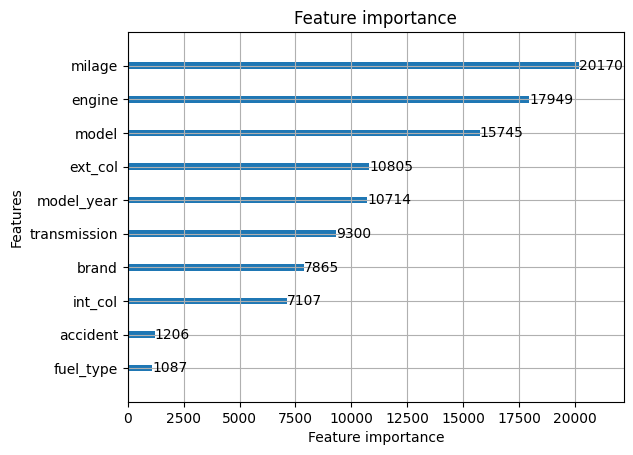

In [59]:
lgbm.plot_importance(hist)

### Test Preprocessing

In [60]:
test[cat_cols] = test[cat_cols].astype('category')

In [61]:
test[cat_cols] = encoder.transform(test[cat_cols])

In [62]:
idx = test['id']
test.drop(columns='id', inplace=True)

In [63]:
cols = test.columns

In [64]:
# test = imputer.transform(test)
# test = pd.DataFrame(test, columns=cols)

In [65]:
# test

In [66]:
# test = test.astype(int)

In [67]:
preds = hist.predict(test)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] lambda_l2 is set=2.2060422296908514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2060422296908514e-06
[LightGBM] [Warning] lambda_l1 is set=6.39421553012287e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39421553012287e-05


In [68]:
submission_df = pd.DataFrame({
    'id':idx,
    'price':preds.flatten()
})

In [69]:
submission_df.to_csv('submission_df.csv', index=False)